In [344]:
%load_ext autoreload
%autoreload 2
import sys

# instead of creating a package using setup.py or building from a docker/singularity file,
# import the sister directory of src code to be called on in notebook.
# This keeps the notebook free from code to only hold visualizations and is easier to test
# It also helps keep the state of variables clean such that cells aren't run out of order with a mysterious state
sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [345]:
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
import seaborn as sns
import matplotlib.dates as mdates
import statistics as st

In [346]:
def date_filter(ldf, time1, time2):
    ldf = ldf[ldf["valid_time"] > time1]
    ldf = ldf[ldf["valid_time"] < time2]

    return ldf

In [347]:
gfs_path = "/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/20240831/ESSX/ESSX_loss_5.902124881744385_ml_output_ESSX.parquet"

nam_path = "/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/20240831/ESSX/ESSX_loss_2.374760627746582_ml_output_ESSX.parquet"

hrrr_path = "/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/20240901/ESSX/ESSX_loss_2.744853985309601_ml_output_ESSX.parquet"

In [348]:
gfs_df = pd.read_parquet(gfs_path).sort_index()

nam_df = pd.read_parquet(nam_path).sort_index()

hrrr_df = pd.read_parquet(hrrr_path).sort_index()

In [349]:
full_gfs = pd.read_parquet(
    "/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/20240831/ESSX/08_31_2024_22:24:46_full_ESSX.parquet"
).sort_values("valid_time")
gfs_times = full_gfs["valid_time"]

full_nam = pd.read_parquet(
    "/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/20240831/ESSX/08_31_2024_19:23:12_full_ESSX.parquet"
).sort_values("valid_time")
nam_times = full_nam["valid_time"]

full_hrrr = pd.read_parquet(
    "/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/20240901/ESSX/09_01_2024_06:17:16_full_ESSX.parquet"
).sort_index()
hrrr_times = full_hrrr["valid_time"]

In [350]:
gfs_df["valid_time"] = gfs_times

nam_df["valid_time"] = nam_times

hrrr_df["valid_time"] = hrrr_times

In [351]:
gfs_df["Model forecast"] = gfs_df["Model forecast"] * 4

nam_df["Model forecast"] = nam_df["Model forecast"] * 2

hrrr_df["Model forecast"] = hrrr_df["Model forecast"] * 1.5

In [352]:
nam_mean = st.mode(nam_df["Model forecast"])
nam_mean

0.08113414794206619

In [353]:
nam_df.head()

,target_error_lead_0,Model forecast,diff,valid_time
0,0.181032,0.081134,0.140465,2022-01-01 12:00:00
1,0.410931,0.004611,0.408625,2022-01-01 18:00:00
2,-2.179034,-0.735138,-1.811465,2022-01-02 00:00:00
3,-1.189100,-0.575696,-0.901252,2022-01-02 06:00:00
4,-0.387064,-0.946758,0.086315,2022-01-02 12:00:00


In [354]:
hrrr_df.head()

,target_error_lead_0,Model forecast,diff,valid_time
0,1.411257,0.177030,1.293237,2018-01-10 00:00:00
1,2.046142,2.646514,0.281800,2018-01-12 12:00:00
2,2.781875,1.875402,1.531607,2018-01-12 13:00:00
3,1.200808,0.178784,1.081618,2018-01-12 14:00:00
4,0.221599,0.532103,-0.133136,2018-01-12 15:00:00


In [355]:
gfs_df.head()

,target_error_lead_0,Model forecast,diff,valid_time
0,1.125590,-0.246490,1.187212,2018-01-10 00:00:00
1,-1.840258,-0.794279,-1.641688,2018-01-10 18:00:00
2,-1.656707,-0.744204,-1.470656,2018-01-11 00:00:00
3,-2.693348,-0.672735,-2.525164,2018-01-11 06:00:00
4,-0.950821,-0.685764,-0.779380,2018-01-11 18:00:00


In [356]:
gfs_df.dropna(inplace=True)
nam_df.dropna(inplace=True)
hrrr_df.dropna(inplace=True)

In [357]:
time1 = datetime(2023, 10, 11, 0, 0, 0)
time2 = datetime(2023, 12, 14, 23, 0, 0)

gfs_df = date_filter(gfs_df, time1, time2)
nam_df = date_filter(nam_df, time1, time2)
hrrr_df = date_filter(hrrr_df, time1, time2)

In [358]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines


def plot_min_diff_based_on_min_abs_error(df1, df2, df3):
    # Ensure 'valid_time' is treated as datetime in all dataframes
    df1["valid_time"] = pd.to_datetime(df1["valid_time"])
    df2["valid_time"] = pd.to_datetime(df2["valid_time"])
    df3["valid_time"] = pd.to_datetime(df3["valid_time"])

    # Calculate absolute error in 'diff' column for each dataframe
    df1["abs_error"] = df1["Model forecast"].abs()
    df2["abs_error"] = df2["Model forecast"].abs()
    df3["abs_error"] = df3["Model forecast"].abs()

    # Merge the dataframes on 'valid_time' to align them
    merged_df = pd.merge_asof(
        df1[["valid_time", "abs_error", "Model forecast"]],
        df2[["valid_time", "abs_error", "Model forecast"]],
        on="valid_time",
        suffixes=("_hrrr", "_nam"),
        direction="nearest",
    )
    merged_df = pd.merge_asof(
        merged_df,
        df3[["valid_time", "abs_error", "Model forecast"]],
        on="valid_time",
        direction="nearest",
    )
    merged_df.rename(
        columns={"abs_error": "abs_error_gfs", "Model forecast": "Model forecast_gfs"},
        inplace=True,
    )
    # Determine the dataframe with the smallest absolute error at each 'valid_time'
    merged_df["source"] = merged_df[
        ["abs_error_hrrr", "abs_error_nam", "abs_error_gfs"]
    ].idxmin(axis=1)

    # Plot the data
    plt.figure(figsize=(12, 6))

    # Iterate over each point and change color depending on the source DataFrame, but plot the actual 'model' value
    for i in range(len(merged_df) - 1):
        current_source = merged_df["source"].iloc[i]
        if current_source == "abs_error_hrrr":
            plt.plot(
                merged_df["valid_time"].iloc[i : i + 2],
                merged_df["Model forecast_hrrr"].iloc[i : i + 2],
                color="red",
            )
        elif current_source == "abs_error_nam":
            plt.plot(
                merged_df["valid_time"].iloc[i : i + 2],
                merged_df["Model forecast_nam"].iloc[i : i + 2],
                color="green",
            )
        elif current_source == "abs_error_gfs":
            plt.plot(
                merged_df["valid_time"].iloc[i : i + 2],
                merged_df["Model forecast_gfs"].iloc[i : i + 2],
                color="blue",
            )

    # Create legend handles
    blue_line = mlines.Line2D([], [], color="blue", label="GFS")
    green_line = mlines.Line2D([], [], color="green", label="NAM")
    red_line = mlines.Line2D([], [], color="red", label="HRRR")

    # Add legend to the plot
    plt.legend(handles=[blue_line, green_line, red_line], title="DataFrame Source")
    x = merged_df["valid_time"]
    # Convert datetime values to numerical values
    x_numeric = mdates.date2num(x)
    # Assuming your timestamps are in a datetime64 format
    day_mask = (x.dt.hour >= 6) & (
        x.dt.hour < 18
    )  # Adjust the hours based on your day/night definition
    # Fill daytime hours with white color
    plt.fill_between(
        x_numeric, -4, 4, where=day_mask, color="white", alpha=0.5, label="Daytime"
    )

    # Fill nighttime hours with grey color
    plt.fill_between(
        x_numeric, -4, 4, where=~day_mask, color="grey", alpha=0.2, label="Nighttime"
    )

    plt.xlabel("Valid Time")
    plt.ylabel("Model Forecast")
    plt.title("Plot of Model Forecast by Valid Time (Based on Minimum Absolute Error)")
    plt.grid(True)
    plt.show()

In [359]:
def get_total_error(df1, df2, df3):
    # Ensure 'valid_time' is treated as datetime in all dataframes
    df1["valid_time"] = pd.to_datetime(df1["valid_time"])
    df2["valid_time"] = pd.to_datetime(df2["valid_time"])
    df3["valid_time"] = pd.to_datetime(df3["valid_time"])

    # Calculate absolute error in 'diff' column for each dataframe
    df1["abs_error"] = df1["Model forecast"].abs()
    df2["abs_error"] = df2["Model forecast"].abs()
    df3["abs_error"] = df3["Model forecast"].abs()

    # Calculate absolute error in 'target' column for each dataframe
    df1["abs_error_target"] = df1["target_error_lead_0"].abs()
    df2["abs_error_target"] = df2["target_error_lead_0"].abs()
    df3["abs_error_target"] = df3["target_error_lead_0"].abs()

    # Merge the dataframes on 'valid_time' to align them
    merged_df = pd.merge_asof(
        df1[["valid_time", "abs_error", "abs_error_target"]],
        df2[["valid_time", "abs_error", "abs_error_target"]],
        on="valid_time",
        suffixes=("_hrrr", "_nam"),
        direction="nearest",
    )
    merged_df = pd.merge_asof(
        merged_df,
        df3[["valid_time", "abs_error", "abs_error_target"]],
        on="valid_time",
        direction="nearest",
    )
    merged_df.rename(
        columns={
            "abs_error": "abs_error_gfs",
            "abs_error_target": "abs_error_target_gfs",
        },
        inplace=True,
    )
    # Determine the dataframe with the smallest absolute error at each 'valid_time'
    merged_df["LSTM_guess"] = merged_df[
        ["abs_error_hrrr", "abs_error_nam", "abs_error_gfs"]
    ].idxmin(axis=1)

    # Determine the dataframe with the smallest real error at each 'valid_time'
    merged_df["truth"] = merged_df[
        ["abs_error_target_hrrr", "abs_error_target_nam", "abs_error_target_gfs"]
    ].idxmin(axis=1)

    correct = 0
    wrong = 0
    total = 0

    hrrr = 0
    nam = 0
    gfs = 0
    for i, _ in enumerate(merged_df["LSTM_guess"]):
        source = merged_df["LSTM_guess"].iloc[i]
        truth = merged_df["truth"].iloc[i]

        if source[-3:] == truth[-3:]:
            correct += 1

        if source[-3:] != truth[-3:]:
            wrong += 1

        if truth[-3:] == "gfs":
            gfs += 1
        if truth[-3:] == "nam":
            nam += 1
        if truth[-3:] == "rrr":
            hrrr += 1

        total += 1

    hrrr_per = (hrrr / total) * 100
    nam_per = (nam / total) * 100
    gfs_per = (gfs / total) * 100

    # Example data
    data = {"Model": ["HRRR", "NAM", "GFS"], "Percentage": [hrrr_per, nam_per, gfs_per]}

    # Create a DataFrame
    df = pd.DataFrame(data)

    # Reshape the data for the heatmap
    df_pivot = df.pivot_table(index="Model", values="Percentage")

    # Create the heatmap
    plt.figure(figsize=(8, 2))  # Adjust the size for better readability
    sns.heatmap(
        df_pivot, vmin=0, vmax=100, annot=True, cmap="Greens", cbar=True, linewidths=1
    )

    # Display the heatmap
    plt.title("Model Percentage Heatmap")
    plt.show()

    final_percent = (correct / total) * 100
    print(f"This Model set up has {final_percent}% Accuracy")

    return merged_df

In [360]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def get_total_error_heatmap(df1, df2, df3):
    # Ensure 'valid_time' is treated as datetime in all dataframes
    df1["valid_time"] = pd.to_datetime(df1["valid_time"])
    df2["valid_time"] = pd.to_datetime(df2["valid_time"])
    df3["valid_time"] = pd.to_datetime(df3["valid_time"])

    # Calculate absolute error in 'diff' column for each dataframe
    df1["abs_error"] = df1["Model forecast"].abs()
    df2["abs_error"] = df2["Model forecast"].abs()
    df3["abs_error"] = df3["Model forecast"].abs()

    # Calculate absolute error in 'target' column for each dataframe
    df1["abs_error_target"] = df1["target_error_lead_0"].abs()
    df2["abs_error_target"] = df2["target_error_lead_0"].abs()
    df3["abs_error_target"] = df3["target_error_lead_0"].abs()

    # Merge the dataframes on 'valid_time' to align them
    merged_df = pd.merge_asof(
        df1[["valid_time", "abs_error", "abs_error_target"]],
        df2[["valid_time", "abs_error", "abs_error_target"]],
        on="valid_time",
        suffixes=("_hrrr", "_nam"),
        direction="nearest",
    )
    merged_df = pd.merge_asof(
        merged_df,
        df3[["valid_time", "abs_error", "abs_error_target"]],
        on="valid_time",
        direction="nearest",
    )
    merged_df.rename(
        columns={
            "abs_error": "abs_error_gfs",
            "abs_error_target": "abs_error_target_gfs",
        },
        inplace=True,
    )

    # Determine the dataframe with the smallest absolute error at each 'valid_time'
    merged_df["LSTM_guess"] = merged_df[
        ["abs_error_hrrr", "abs_error_nam", "abs_error_gfs"]
    ].idxmin(axis=1)

    # Determine the dataframe with the smallest real error at each 'valid_time'
    merged_df["truth"] = merged_df[
        ["abs_error_target_hrrr", "abs_error_target_nam", "abs_error_target_gfs"]
    ].idxmin(axis=1)

    # Extract model names from columns
    merged_df["LSTM_guess"] = merged_df["LSTM_guess"].apply(
        lambda x: x.split("_")[-1].upper()
    )
    merged_df["truth"] = merged_df["truth"].apply(lambda x: x.split("_")[-1].upper())

    # Create a confusion matrix-style DataFrame
    heatmap_data = pd.crosstab(merged_df["truth"], merged_df["LSTM_guess"])

    # Normalize the data by the total number of predictions
    heatmap_data = (heatmap_data / heatmap_data.sum().sum()) * 100

    # Create the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        heatmap_data,
        annot=True,
        vmin=0,
        vmax=100,
        cmap="Blues",
        cbar=True,
        linewidths=1,
        fmt=".2f",
    )

    plt.title("Heatmap of LSTM Guess vs Correct Model (Percentages)")
    plt.xlabel("LSTM Guessed Model")
    plt.ylabel("Correct Model")
    plt.show()

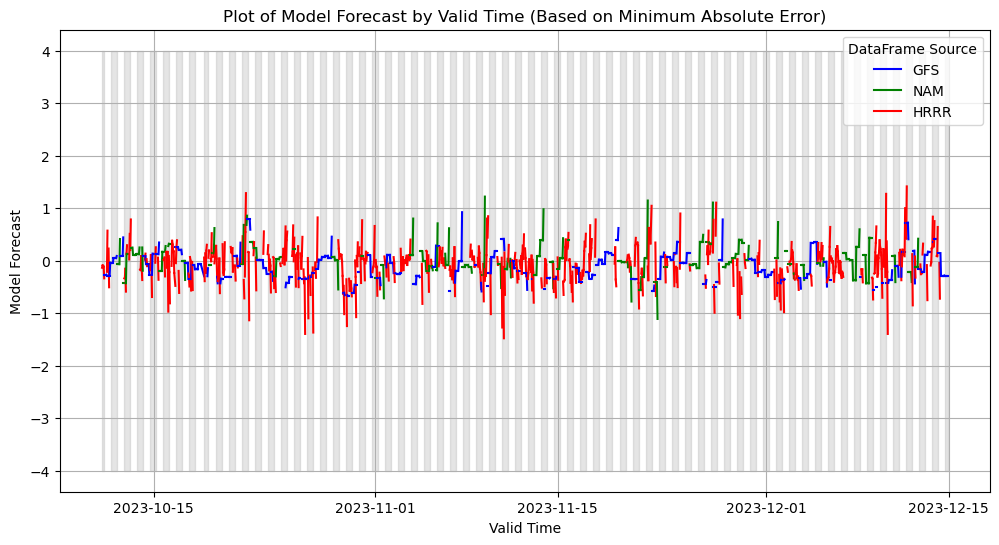

In [361]:
plot_min_diff_based_on_min_abs_error(hrrr_df, nam_df, gfs_df)

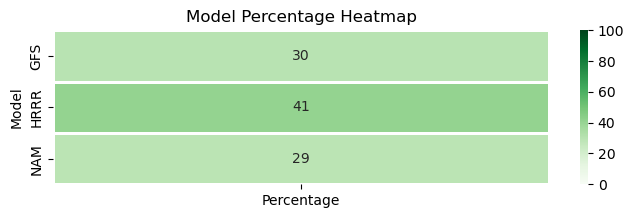

This Model set up has 34.3042071197411% Accuracy


In [362]:
final_df = get_total_error(hrrr_df, nam_df, gfs_df)

In [363]:
final_df

,valid_time,abs_error_hrrr,abs_error_target_hrrr,abs_error_nam,abs_error_target_nam,abs_error_gfs,abs_error_target_gfs,LSTM_guess,truth
0,2023-10-11 01:00:00,0.133408,0.310984,0.384953,0.862644,0.264903,1.163719,abs_error_hrrr,abs_error_target_hrrr
1,2023-10-11 02:00:00,0.089456,0.158435,0.384953,0.862644,0.264903,1.163719,abs_error_hrrr,abs_error_target_hrrr
2,2023-10-11 03:00:00,0.098856,0.371564,0.384953,0.862644,0.264903,1.163719,abs_error_hrrr,abs_error_target_hrrr
3,2023-10-11 04:00:00,0.115956,0.598456,0.384953,0.862644,0.264903,1.163719,abs_error_hrrr,abs_error_target_hrrr
4,2023-10-11 05:00:00,0.335107,0.386942,0.384953,0.862644,0.264903,1.163719,abs_error_gfs,abs_error_target_hrrr
...,...,...,...,...,...,...,...,...,...
1540,2023-12-14 18:00:00,0.938157,1.726531,0.473047,1.312597,0.282117,1.481035,abs_error_gfs,abs_error_target_nam
1541,2023-12-14 19:00:00,0.510123,1.076550,0.473047,1.312597,0.282117,1.481035,abs_error_gfs,abs_error_target_hrrr
1542,2023-12-14 20:00:00,0.442102,1.505166,0.473047,1.312597,0.282117,1.481035,abs_error_gfs,abs_error_target_nam
1543,2023-12-14 21:00:00,0.616272,1.753348,0.473047,1.312597,0.282117,1.481035,abs_error_gfs,abs_error_target_nam


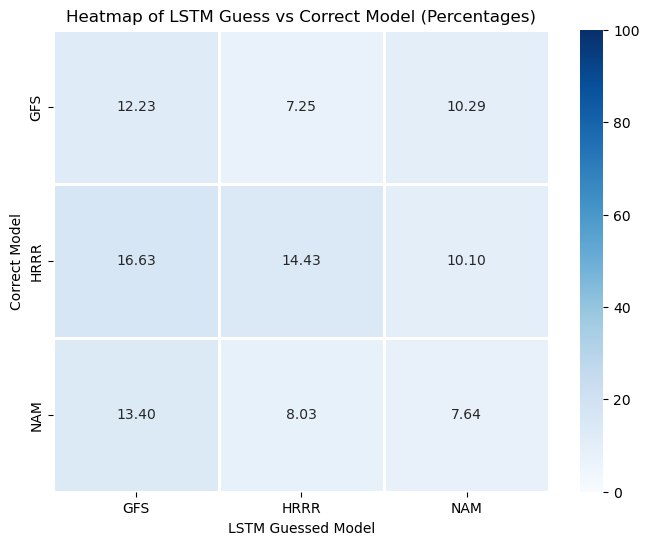

In [364]:
get_total_error_heatmap(hrrr_df, nam_df, gfs_df)